# **Projeto 2 - Previsão de Séries Temporais com Machine Learning**

## **Imports e geração da série**

Bibliotecas necessárias para manipulação de dados, visualização e construção do modelo escolhido.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Para aumentar a consistência dos experimentos, são definidas seeds para todas as bibliotecas que utilizam aleatoriedade.
Apesar disso, pequenas variações entre execuções ainda podem ocorrer, pois o backend MPS (Apple Silicon) não é totalmente determinístico em operações utilizadas pela LSTM.

In [2]:
device = torch.device("mps" 
                      if torch.backends.mps.is_available() 
                      else "cpu")
print("Device:", device)

Device: mps


In [50]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)

Define uma função auxiliar para padronizar a aparência dos gráficos ao longo do notebook.

In [51]:
def plot_pretty(figsize=(12, 5), 
                xlabel=None, ylabel=None, title=None):
    """
    Estabelece um estilo padrão para os gráficos.
    """
    # Estilo global
    plt.style.use("seaborn-v0_8-whitegrid")

    # Cria figura e eixos
    fig, ax = plt.subplots(figsize=figsize)

    # Grid suave
    ax.grid(True, linestyle="--", alpha=0.6, which="both", axis="both")

    # Remover bordas superiores e direita
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Ticks
    ax.tick_params(labelsize=10)

    # Labels (se fornecidos)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=11, labelpad=8)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=11, labelpad=8)
    if title is not None:
        ax.set_title(title, fontsize=13, pad=10, weight="semibold")

    return ax

Lê o dataset de emissões globais, ajusta o índice temporal e plota a série para inspeção inicial.

In [ ]:
df = pd.read_csv('co2_emissions_processed.csv')

# Converter coluna year para índice
df["year"] = pd.to_datetime(df["year"], format="%Y")
df = df.set_index("year")

# Série
serie = df["total_ghg"].values

In [80]:
# Quantidade de dados
n_points = len(serie)
n_points

174

Como é possível perceber no gráfico a seguir, a série apresenta uma tendência crescente ao longo de todo o período analisado. O aumento se acelera principalmente após a metade do século XX, refletindo a intensificação da atividade industrial.  

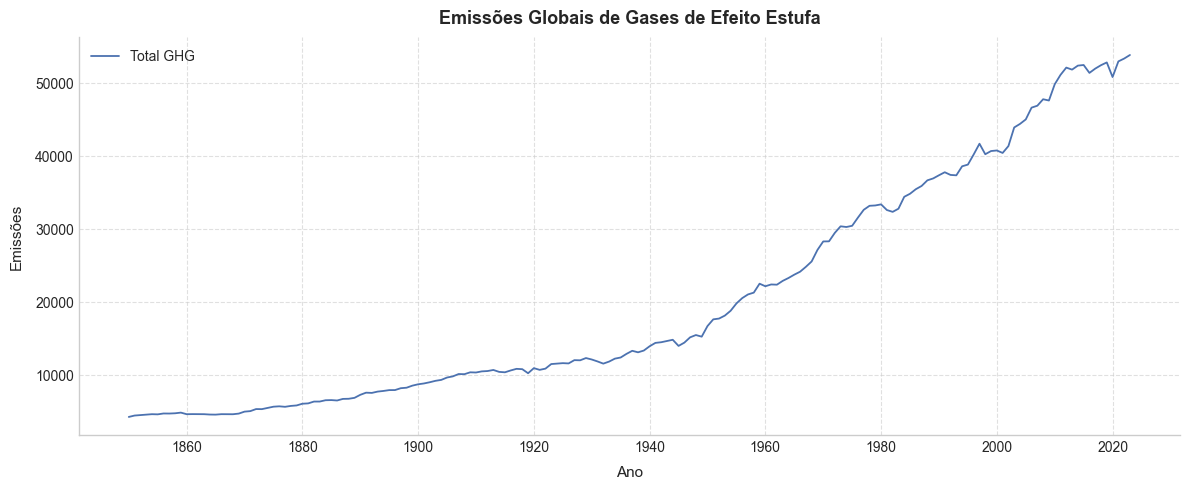

In [55]:
ax = plot_pretty(
    figsize=(12, 5),
    xlabel="Ano",
    ylabel="Emissões",
    title="Emissões Globais de Gases de Efeito Estufa"
)

ax.plot(df.index, df["total_ghg"], linewidth=1.3, color="#4C72B0", label="Total GHG")

ax.legend(frameon=False)
plt.tight_layout()
plt.show()

## **Janela deslizante + train/test + escala**

Nesta etapa, a série é preparada para o treinamento da rede.  
Utiliza-se uma janela deslizante de 3 passos, na qual os três valores anteriores são usados para prever o próximo ponto.  
O tamanho 3 foi escolhido por ser suficiente para capturar dependências locais da série sem inflar demasiadamente a dimensionalidade da entrada, algo importante em séries anuais e com poucos dados disponíveis.  
Após definir as janelas, a série é dividida em treino e teste (80/20) e normalizada, garantindo estabilidade numérica durante o aprendizado.

In [56]:
# Janela de 3 passos de tempo
time_steps=3

A função abaixo reorganiza a série temporal em pares entrada–saída.  
Cada janela de `time_steps` pontos consecutivos compõe uma entrada **X**,  
e o valor imediatamente seguinte torna-se o alvo **y**.

Por exemplo, para a série `[x1, x2, x3, x4, x5, x6]` com `time_steps = 3`,  
a primeira amostra gerada será:

- **X:** `[x1, x2, x3]`  
- **y:** `x4`

Esse formato permite que a LSTM aprenda a relação entre uma sequência passada e o próximo valor da série.

In [57]:
def create_dataset(series, time_steps=time_steps):
    """
    Cria datasets de séries temporais.
    
    Args:
        series (array-like): Série temporal original.
        time_steps (int): Número de passos de tempo (janela).
        
    Returns:
        X (np.array): Dados de entrada com shape (num_amostras, time_steps).
        y (np.array): Valores alvo com shape (num_amostras,).
    """
    X, y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i:i+time_steps])
        y.append(series[i+time_steps])
    return np.array(X), np.array(y)

In [58]:
# Split 80%/20%
train_size = int(len(serie) * 0.8)
serie_train = serie[:train_size]
serie_test  = serie[train_size:]

In [59]:
print("Tamanho treino:", len(serie_train))
print("Tamanho teste :", len(serie_test))

Tamanho treino: 139
Tamanho teste : 35


In [60]:
# Escala
scaler = StandardScaler()
serie_train_scaled = scaler.fit_transform(serie_train.reshape(-1, 1)).flatten()
serie_test_scaled  = scaler.transform(serie_test.reshape(-1, 1)).flatten()

In [61]:
# Conjuntos (X,y)
X_train, y_train = create_dataset(serie_train_scaled, time_steps)
X_test,  y_test  = create_dataset(serie_test_scaled,  time_steps)

In [62]:
print("X_train shape:", X_train.shape)  # [N_train, time_steps]
print("X_test shape :", X_test.shape)   # [N_test, time_steps]

X_train shape: (136, 3)
X_test shape : (32, 3)


In [63]:
print("y_train shape:", y_train.shape)  # [N_train,]
print("y_test shape :", y_test.shape)   # [N_test,]

y_train shape: (136,)
y_test shape : (32,)


## **Dataset + DataLoader em PyTorch**

Os dados não são enviados para a LSTM de uma vez só.  
O `DataLoader` divide o conjunto de treino em pequenos grupos (mini-batches),  
o que reduz o custo computacional e torna o processo de otimização mais estável.

No conjunto de treino há 136 janelas, cada uma com 3 valores (`X.shape = (136, 3)`).  
Com `batch_size = 32`, o `DataLoader` cria lotes como:

- Batch 1 → 32 amostras  
- Batch 2 → 32 amostras  
- Batch 3 → 32 amostras  
- Batch 4 → 32 amostras  
- Batch 5 → 8 amostras (restante)

Assim, em vez de enviar 136 janelas ao modelo de uma vez, enviam-se 32 por etapa.

Cada mini-batch assume o formato esperado pela LSTM:

`[batch, seq_len, features] = [32, 3, 1]`

onde:

- **32** → número de amostras no lote  
- **3** → tamanho da janela temporal  
- **1** → número de variáveis (emissões)

In [64]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # X: [N, time_steps], y: [N]
        # LSTM espera [batch, seq_len, features] se batch_first=True
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # -> [N, T, 1]
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # -> [N, 1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset  = TimeSeriesDataset(X_test,  y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

for xb, yb in train_loader:
    print("Batch X shape:", xb.shape)  # [batch, seq_len, features]
    print("Batch y shape:", yb.shape)  # [batch, 1]

Batch X shape: torch.Size([32, 3, 1])
Batch y shape: torch.Size([32, 1])
Batch X shape: torch.Size([32, 3, 1])
Batch y shape: torch.Size([32, 1])
Batch X shape: torch.Size([32, 3, 1])
Batch y shape: torch.Size([32, 1])
Batch X shape: torch.Size([32, 3, 1])
Batch y shape: torch.Size([32, 1])
Batch X shape: torch.Size([8, 3, 1])
Batch y shape: torch.Size([8, 1])


## **Modelo LSTM**

Implementa-se aqui a arquitetura LSTM utilizada nas previsões.  
O modelo recebe sequências no formato `[batch, seq_len, features]`, processa-as pela LSTM e utiliza a última saída temporal para gerar a previsão final por meio de uma camada totalmente conectada.

In [65]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, num_layers=1):
        super().__init__()
        # batch_first=True -> entrada [batch, seq, feature]
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, input_size]
        output, (h_n, c_n) = self.lstm(x)
        # output: [batch, seq_len, hidden_size]
        last_output = output[:, -1, :]  # pega o último passo de tempo
        out = self.fc(last_output)      # [batch, 1]
        return out

model = LSTMRegressor(input_size=1, hidden_size=32, num_layers=1).to(device)
print(model)

LSTMRegressor(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## **Treino (MSE + Adam)**

Define-se a função de perda (MSE) e o otimizador (Adam) e, em seguida, executa-se o ciclo de treinamento.  
A cada batch, o modelo realiza o forward pass, calcula o erro, realiza o backpropagation e atualiza os pesos.  
Ao final de cada época, a perda média é registrada para acompanhar a convergência.

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_dataset)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1} - Loss {epoch_loss:.6f}")

Epoch 100 - Loss 0.009016
Epoch 200 - Loss 0.004705
Epoch 300 - Loss 0.002951
Epoch 400 - Loss 0.002576
Epoch 500 - Loss 0.002459
Epoch 600 - Loss 0.002287
Epoch 700 - Loss 0.002055
Epoch 800 - Loss 0.002121
Epoch 900 - Loss 0.001782
Epoch 1000 - Loss 0.005651


## **Avaliação da LSTM**

### **Previsão (conjunto de teste)**

Coloca-se o modelo em modo de avaliação e são geradas as previsões para o conjunto de teste.  
As saídas da LSTM, normalizadas durante o treinamento, são então convertidas de volta para a escala original da série.  
Em seguida, são calculadas as principais métricas de desempenho (MSE, RMSE, MAE e R²).

In [67]:
model.eval()
y_pred_list = []

# Gerar previsões do modelo sem a necessidade de salvar os gradientes
with torch.no_grad():
    # Itera sobre os dados de teste em mini-lotes (batches)
    for X_batch, y_batch in test_loader:
        # Envia o batch de entrada para o dispositivo (GPU ou CPU)
        # para que esteja no mesmo local que o modelo
        X_batch = X_batch.to(device)
        # Realiza o "Forward Pass" (passagem para frente):
        # O modelo recebe a sequência histórica e retorna a previsão
        preds = model(X_batch)
        # 1. Move o tensor de volta para a CPU (.cpu()) pois o NumPy não roda na GPU
        # 2. Converte de Tensor para Array NumPy (.numpy())
        # 3. Adiciona à lista de previsões
        y_pred_list.append(preds.cpu().numpy())

# Empilhar previsões (escala normalizada)
y_pred_scaled = np.vstack(y_pred_list).flatten()
y_test_scaled = y_test.copy()
y_train_scaled = y_train.copy()

# Voltar para a escala original (apenas os alvos usados na LSTM)
y_test_inv  = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()   # len = 32
y_pred_inv  = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()   # len = 32
y_train_inv = scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()  # len = 136

# Calcular métricas da LSTM automaticamente
mse_lstm = mean_squared_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
r2_lstm = r2_score(y_test_inv, y_pred_inv)
n_lstm = len(y_test_inv)

### **Ajuste dos anos e valores reais**

Reconstrói-se a série em escala original e separa-se o índice temporal entre treino e teste.  
Como a LSTM utiliza janelas de `time_steps` valores, os anos também são ajustados para refletir essa defasagem.  
Por fim, prepara-se um vetor com as previsões posicionadas corretamente ao longo do trecho de teste.

In [68]:
years = df.index  # índice de datas (1850...2023)

years_train_full = years[:train_size]   # 139 anos
years_test_full  = years[train_size:]   # 35 anos

# Reconstroi a série em escala original
train_full_inv = scaler.inverse_transform(
    serie_train_scaled.reshape(-1, 1)
).flatten()   # len = 139

test_full_inv = scaler.inverse_transform(
    serie_test_scaled.reshape(-1, 1)
).flatten()   # len = 35

# Anos usados na LSTM (já alinhados às janelas)
years_train = years_train_full[time_steps:]   # len = 136
years_test  = years_test_full[time_steps:]    # len = 32

y_pred_full_plot = np.full_like(test_full_inv, np.nan, dtype=float)
y_pred_full_plot[time_steps:] = y_pred_inv  # coloca as 32 previsões a partir do 4º ponto

print("Train years (LSTM):", len(years_train), "| y_train_inv:", len(y_train_inv))
print("Test  years (LSTM):", len(years_test),  "| y_test_inv :", len(y_test_inv))

Train years (LSTM): 136 | y_train_inv: 136
Test  years (LSTM): 32 | y_test_inv : 32


### **Gráficos**

Os gráficos abaixo comparam os valores reais com as previsões da LSTM.  
No primeiro, visualiza-se apenas o trecho de teste.  
No segundo, apresenta-se toda a série, com destaque visual para o período de teste e para as previsões geradas pelo modelo.

De maneira geral, a LSTM acompanha a tendência do período de teste, mantendo previsões próximas aos valores reais. Já a diferença entre as curvas aparece em alguns picos e vales, onde o modelo suaviza oscilações, mas sem perder a direção geral da série.

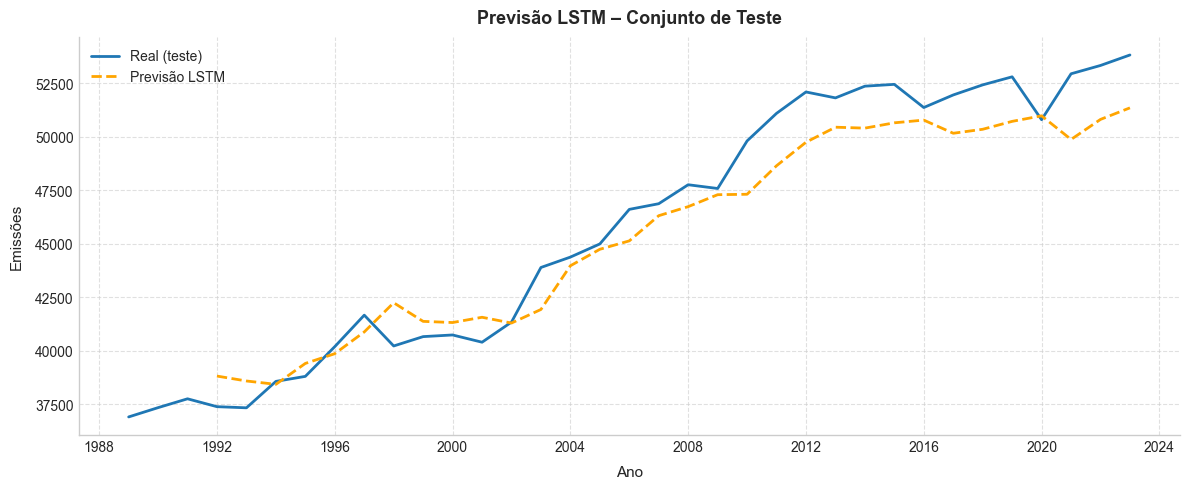

In [77]:
# Teste
ax = plot_pretty(
    figsize=(12, 5),
    xlabel="Ano",
    ylabel="Emissões",
    title="Previsão LSTM – Conjunto de Teste"
)

# Real (teste completo – 35 pontos)
ax.plot(years_test_full, test_full_inv, label="Real (teste)", linewidth=2, color="#1f77b4")

# Previsão LSTM (aparece a partir do 4º ponto)
ax.plot(years_test_full, y_pred_full_plot, label="Previsão LSTM", linewidth=2,
        linestyle="--", color="orange")

ax.legend(frameon=False)
plt.tight_layout()
plt.show()

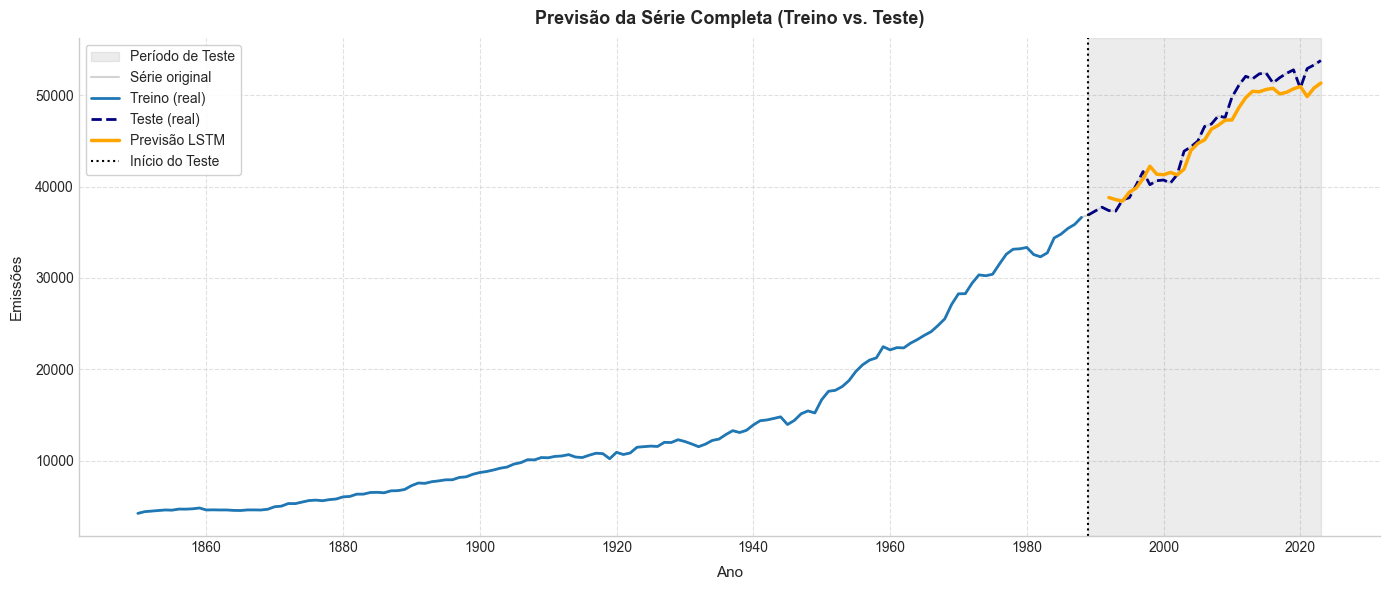

In [ ]:
ax = plot_pretty(
    figsize=(14, 6),
    xlabel="Ano",
    ylabel="Emissões",
    title="Previsão da Série Completa (Treino vs. Teste)"
)

# Adicionar a faixa de fundo (Sombreado na área de teste)
ax.axvspan(
    years_test_full[0],   # Data inicial do teste
    years_test_full[-1],  # Data final do teste
    color='gray',
    alpha=0.15,           # Transparência
    label="Período de Teste"
)

# Série original completa (fundo)
ax.plot(df.index, df["total_ghg"].values, color="lightgray", linewidth=1.5,
        label="Série original")

# Treino (real)
ax.plot(
    years_train_full,
    train_full_inv,
    label="Treino (real)",
    color="#1f77b4",
    linewidth=2
)

# Teste (real)
ax.plot(
    years_test_full,
    test_full_inv,
    label="Teste (real)",
    color="navy",
    linestyle="--",
    linewidth=2
)

# Previsão LSTM no teste
ax.plot(
    years_test_full,
    y_pred_full_plot,
    label="Previsão LSTM",
    color="orange",
    linewidth=2.5
)

# Linha vertical marcando a separação
ax.axvline(years_test_full[0], color="black", linestyle=":", linewidth=1.5, label="Início do Teste")

# Legenda com fundo branco para facilitar a leitura sobre o sombreado
ax.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)

plt.tight_layout()
plt.show()

## **Comparação - LSTM x ARIMA**

Carregam-se as previsões do ARIMA, desfaz-se a transformação logarítmica e alinham-se os 32 últimos pontos para que ambos os modelos sejam avaliados exatamente sobre o mesmo intervalo de teste.  
Em seguida, são calculadas as métricas do ARIMA e gerado o gráfico comparando valores reais, ARIMA e LSTM.

A partir dos gráficos, é possível perceber que o ARIMA mantém uma tendência linear crescente e acaba superestimando boa parte dos valores do período de teste. Já a LSTM acompanha melhor as oscilações reais da série, preservando a forma da curva e produzindo previsões mais próximas das observações ao longo do tempo.

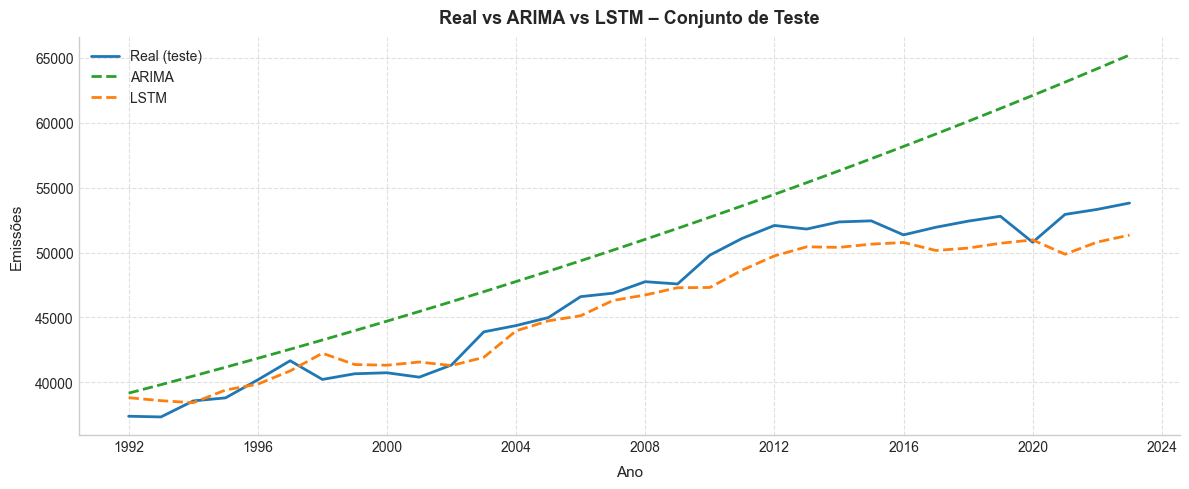

In [78]:
# Carregando previsões do ARIMA
fc_arima_log = np.load("fc_arima_log.npy")

# Invertendo a transformação logarítmica
fc_arima_inv = np.exp(fc_arima_log)

# Alinhando com as previsões da LSTM (removendo os primeiros 'time_steps' pontos do ARIMA também)
# para que os modelos sejam avaliados nos mesmos 32 pontos de dados
fc_arima_inv_aligned = fc_arima_inv[time_steps:]
y_test_inv_aligned = y_test_inv # Já está alinhado (32 pontos)

# Calcular métricas do ARIMA
mse_arima = mean_squared_error(y_test_inv_aligned, fc_arima_inv_aligned)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(y_test_inv_aligned, fc_arima_inv_aligned)
r2_arima = r2_score(y_test_inv_aligned, fc_arima_inv_aligned)
n_arima = len(fc_arima_inv_aligned)

ax = plot_pretty(
    figsize=(12, 5),
    xlabel="Ano",
    ylabel="Emissões",
    title="Real vs ARIMA vs LSTM – Conjunto de Teste"
)

# Plotar apenas os dados alinhados (32 pontos)
ax.plot(years_test, y_test_inv_aligned, label="Real (teste)", linewidth=2, color="#1f77b4")
ax.plot(years_test, fc_arima_inv_aligned, label="ARIMA", linewidth=2, linestyle="--", color="tab:green")
ax.plot(years_test, y_pred_inv, label="LSTM", linewidth=2, linestyle="--", color="tab:orange")

ax.legend(frameon=False)
plt.tight_layout()
plt.show()

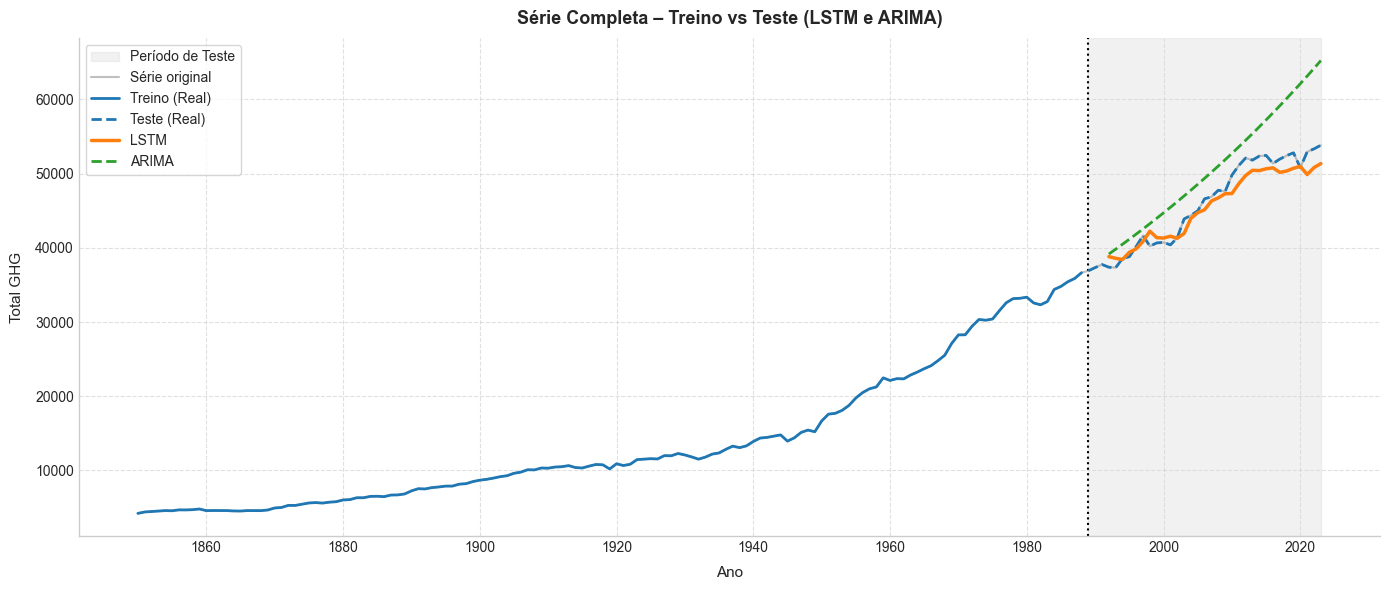

In [72]:
ax = plot_pretty(
    figsize=(14, 6),
    xlabel="Ano",
    ylabel="Total GHG",
    title="Série Completa – Treino vs Teste (LSTM e ARIMA)"
)

# Sombreamento na área de teste
ax.axvspan(
    years_test_full[0],   # Início exato do teste
    years_test_full[-1],  # Fim do teste
    color='lightgray', 
    alpha=0.3, 
    label="Período de Teste"
)

# Linha vertical marcando a separação
ax.axvline(
    years_test_full[0],
    color="black",
    linestyle=":",
    linewidth=1.5,
    zorder=2 # Garante que fique na frente do fundo
)

# A. Série Original (Cinza no fundo para contexto)
ax.plot(
    df.index,
    df["total_ghg"].values,
    color="gray",
    linewidth=1.5,
    alpha=0.5,
    label="Série original"
)

# B. Treino (Real - Azul contínuo)
ax.plot(
    years_train_full,
    train_full_inv,
    label="Treino (Real)",
    color="#1f77b4",
    linewidth=2
)

# C. Teste (Real - Azul tracejado)
ax.plot(
    years_test_full,
    test_full_inv,
    label="Teste (Real)",
    color="#1f77b4",
    linestyle="--",
    linewidth=2
)

# D. Previsão LSTM (Laranja)
ax.plot(
    years_test,
    y_pred_inv,
    label="LSTM",
    color="#ff7f0e",
    linewidth=2.5
)

# E. Previsão ARIMA (Verde tracejado)
ax.plot(
    years_test,
    fc_arima_inv_aligned,
    label="ARIMA",
    color="tab:green",
    linestyle="--",
    linewidth=2
)

# Legenda organizada
ax.legend(loc='upper left', frameon=True, facecolor='white')

plt.tight_layout()
plt.show()

Após gerar as previsões de ambos os modelos, as principais métricas de desempenho são reunidas em um único DataFrame.
Em seguida, calcula-se a melhora percentual da LSTM em relação ao ARIMA, permitindo avaliar e comparar o desempenho de cada abordagem no período de teste.

In [29]:
# Criar DataFrame de resultados
resultados = pd.DataFrame([
    {
        "Modelo": "ARIMA",
        "MSE":    mse_arima,
        "RMSE":   rmse_arima,
        "MAE":    mae_arima,
        "R2":     r2_arima,
        "n":      n_arima
    },
    {
        "Modelo": "LSTM",
        "MSE":    mse_lstm,
        "RMSE":   rmse_lstm,
        "MAE":    mae_lstm,
        "R2":     r2_lstm,
        "n":      n_lstm
    }
])

print(resultados)

# melhorias percentuais (LSTM em relação ao ARIMA)
improv_rmse = (rmse_arima - rmse_lstm) / rmse_arima * 100
improv_mae  = (mae_arima  - mae_lstm ) / mae_arima  * 100
improv_mse  = (mse_arima  - mse_lstm ) / mse_arima  * 100

print(f"\nRedução de MSE  (LSTM vs ARIMA): {improv_mse:.2f}%")
print(f"Redução de RMSE (LSTM vs ARIMA): {improv_rmse:.2f}%")
print(f"Redução de MAE  (LSTM vs ARIMA): {improv_mae:.2f}%")

  Modelo           MSE         RMSE          MAE        R2   n
0  ARIMA  3.022643e+07  5497.856452  4655.345776  0.022424  32
1   LSTM  2.484190e+06  1576.131236  1319.546493  0.919657  32

Redução de MSE  (LSTM vs ARIMA): 91.78%
Redução de RMSE (LSTM vs ARIMA): 71.33%
Redução de MAE  (LSTM vs ARIMA): 71.66%


## **Conclusão**
Os resultados obtidos mostram que a LSTM apresentou desempenho substancialmente superior ao ARIMA na tarefa de previsão das emissões globais de gases de efeito estufa. Mesmo com um conjunto relativamente pequeno de dados e com uma janela curta de três anos, a rede neural foi capaz de capturar tanto a tendência de longo prazo quanto as oscilações recentes da série, algo que o modelo tradicional não conseguiu reproduzir de forma satisfatória. As métricas confirmam essa diferença: a LSTM reduziu o MSE em aproximadamente 92%, além de apresentar quedas superiores a 70% em RMSE e MAE. O coeficiente de determinação também evidenciou essa discrepância, passando de apenas 0,02 no ARIMA para cerca de 0,92 na LSTM, indicando que a rede explica praticamente toda a variabilidade observada no período de teste.